## Import

In [12]:
#################################
# # when running google colab # #
#################################
# from google.colab import drive
# drive.mount('/content/gdrive')
# !pip install scikeras --quiet

In [44]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from keras.utils.np_utils import to_categorical 
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, \
    BatchNormalization, Flatten, LSTM
# from scikeras.wrappers import KerasClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import load_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import roc_curve, auc

from itertools import cycle
from scipy import interp
from scipy.optimize import brentq
from scipy.interpolate import interp1d

N_FEATURES = 31
TIMESTEPS = 1
DATASET_LINK = "dataset/overall.csv"
TEST_DATA_LINK = "dataset/overall_test.csv"

# random seed for reproducibility
SEED = 123

### LOAD DATASET
> * Check for class imbalance

In [45]:
# loading of dataset
df = pd.read_csv(DATASET_LINK)

df.head()

,subject,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,...,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
0,Andy,1,1,0.142176,0.156880,0.014704,0.127937,0.142299,0.014361,0.155919,...,0.128263,0.085967,-0.042296,0.120442,0.209372,0.088930,0.116911,0.165437,0.048526,0.160258
1,Andy,1,2,0.141793,0.164635,0.022842,0.121625,0.152146,0.030520,0.137039,...,0.144490,0.082397,-0.062093,0.101188,0.126066,0.024878,0.098424,0.130661,0.032238,0.173819
2,Andy,1,3,0.157152,0.147220,-0.009932,0.134796,0.145790,0.010994,0.124892,...,0.135452,0.082423,-0.053029,0.108598,0.155843,0.047244,0.118759,0.146550,0.027791,0.173512
3,Andy,1,4,0.158673,0.142487,-0.016186,0.118908,0.159179,0.040271,0.133175,...,0.114266,0.072556,-0.041711,0.101937,0.145692,0.043755,0.096300,0.122580,0.026280,0.190808
4,Andy,1,5,0.166583,0.157102,-0.009480,0.115094,0.141103,0.026009,0.135121,...,0.125474,0.089247,-0.036227,0.114211,0.149136,0.034925,0.121197,0.230113,0.108917,0.143299


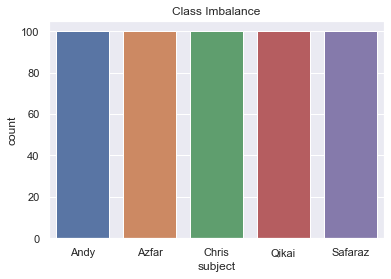

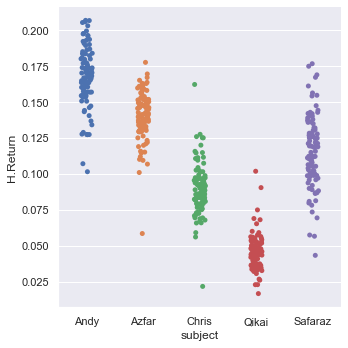

In [46]:
#################################
# # check for class imbalance # #
#################################

sns.set_theme(style="darkgrid")
ax = sns.countplot(x="subject", data=df).set_title("Class Imbalance")

# remove missing values if available
df = df.dropna()

sns.catplot(x="subject", y="H.Return", data=df)

### PREPARING DATASET
> * Split data into X and Y 
> * Convert Y into one-hot-encoding

In [47]:
dataset = df.values

# divide data into features X and target (classes) Y
X = dataset[:,3:].astype(float)
Y = dataset[:,0]

# convert target Y to one hot encoded Y for model
Y = Y.reshape(-1, 1)
encoder = OneHotEncoder().fit(Y)
Y = encoder.transform(Y).toarray()

#################################
# # get all the encoded class # #
#################################
print("Encoder is able to decipher: ")
print(encoder.get_feature_names_out())
print("\n")

###########################
# # print X and Y shape # #
###########################
print("X dataset shape: " + str(X.shape))
print("Y dataset shape: " + str(Y.shape))

Encoder is able to decipher: 
['x0_Andy' 'x0_Azfar' 'x0_Chris' 'x0_Qikai' 'x0_Safaraz']


X dataset shape: (500, 31)
Y dataset shape: (500, 5)


### SPLITTING DATASET
> * Split data into train and test dataset 
> * Normalisation performed based on X_train
> * Reshaping of dataset for LSTM Timesteps

In [17]:
##############################################################
# # split dataset into train and test set of 0.8/0.2 ratio # #
##############################################################
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=SEED)


##############################################
# # normalisation and reshaping of dataset # #
##############################################
# normalisation to 0 to 1
# scaler = MinMaxScaler(feature_range=(0, 1))
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# reshaping the dataset to include LSTM Timesteps
X_train = np.asarray(X_train, dtype=np.float32)
X_train = np.reshape(X_train, (X_train.shape[0], TIMESTEPS, X_train.shape[1]))
X_test = np.asarray(X_test, dtype=np.float32)
X_test = np.reshape(X_test, (X_test.shape[0], TIMESTEPS, X_test.shape[1]))

# retrieve number of classes
n_classes = y_train.shape[1]

print("X train shape: " + str(X_train.shape))
print("Y train shape: " + str(y_train.shape))
print("X test shape: " + str(X_test.shape))
print("Y test shape: " + str(y_test.shape))

X train shape: (400, 1, 31)
Y train shape: (400, 5)
X test shape: (100, 1, 31)
Y test shape: (100, 5)


### CREATE MODEL
> * Create base model
> * Wrap it with KerasClassifier

In [18]:
# create base model
def create_base_model():
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, 
                 input_shape=(TIMESTEPS,N_FEATURES)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    # softmax for multi-class classification
    model.add(Flatten())
    model.add(Dense(n_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam',
                metrics=['accuracy'])
    return model

# wrap model in KerasClassifier
def create_model():
    model = KerasClassifier(build_fn=create_base_model, epochs=100, 
                            batch_size=10)
    return model

### INITIATE KFOLD VALIDATION
> * evaluate best kfold validation
> * generate loss and accuracy graph
> * perform actual kfold validation

##### evaluate suitable folds for kfold validation

In [8]:
# from sklearn.model_selection import LeaveOneOut
def evaluate_kfold(X_train, y_train, SEED):
    
    # evaluate the model    
    folds = range(2,11)
    means, mins, maxs = list(), list(), list()
    
    # evaluate each k value
    for k in folds:
        # define the test condition
        kfold = KFold(n_splits=k, shuffle=True, random_state=SEED)
        # evaluate k value
        model = create_model()
        scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=kfold, n_jobs=-1)
        print(scores)
        k_mean = np.mean(scores)
        k_min = scores.min()
        k_max = scores.max()
        
        # report performance
        print('> folds=%d, accuracy=%.3f%% (min=%.3f%%, max=%.3f%%)' %
              (k, k_mean*100, k_min*100, k_max*100))
        
        # store mean accuracy
        means.append(k_mean)
        
        # store min and max relative to the mean
        mins.append(k_mean - k_min)
        maxs.append(k_max - k_mean)
        
    # line plot of k mean values with min/max error bars
    pyplot.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
    
    # show the plot
    pyplot.show()
    
evaluate_kfold(X_train, y_train, SEED)

NameError: name 'LeaveOneOut' is not defined

##### generate kfold validation accuracy and loss

In [ ]:
##################################################
# # evaluate kfold model for accuracy and loss # #
##################################################
def evaluate_kfold_model(X_train, y_train, SEED):
    scores, histories = list(), list()
    # create model
    model = create_model()
    # prepare cross validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=SEED)
    # enumerate splits
    for train_ix, test_ix in kfold.split(X_train):
        # select rows for train and test
        trainX, trainY, testX, testY = X_train[train_ix], y_train[train_ix], X_train[test_ix], y_train[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=100, batch_size=10, validation_data=(testX, testY), verbose=0)
        
        # evaluate model
        y_pred = model.predict(testX)
        y_pred = to_categorical(y_pred)

        # evaluate predictions
        acc = accuracy_score(testY, y_pred)
        print("Testing accuracy: %.3f%%" % (acc*100))

        # stores scores and histories
        scores.append(acc)
        histories.append(history)

    for i in range(len(histories)):
        # plot loss
        f1 = plt.figure(1)
        plt.title('Categorical Cross-Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue')
        plt.plot(histories[i].history['val_loss'], color='orange')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')

        # plot accuracy
        f2 = plt.figure(2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue')
        plt.plot(histories[i].history['val_accuracy'], color='orange')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='lower right')

    # print summary
    print('Accuracy: Mean=%.3f Std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
    # box and whisker plots of results
    f3 = plt.figure(3)
    plt.title('Box and Whisker Plot of Accuracy Scores')
    plt.ylabel('accuracy')
    plt.xlabel('model')
    plt.boxplot(scores)
    plt.show()
    
evaluate_kfold_model(X_train, y_train, SEED)

##### perform actual KFold Validation

In [21]:
# create model
model = create_model()

n_folds = 10
kfold = KFold(n_splits=n_folds, shuffle=True,
              random_state=SEED)

valid_score = cross_val_score(model, X_train, y_train, 
                          cv=kfold, error_score="raise", verbose=0)

Epoch 1/100
20/20 [==============================] - 4s 5ms/step - loss: 1.6635 - accuracy: 0.3700
Epoch 2/100
20/20 [==============================] - 0s 5ms/step - loss: 1.1177 - accuracy: 0.5950
Epoch 3/100
20/20 [==============================] - 0s 5ms/step - loss: 0.9310 - accuracy: 0.7100
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 0.7669 - accuracy: 0.6900
Epoch 5/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6465 - accuracy: 0.7500
Epoch 6/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6504 - accuracy: 0.7650
Epoch 7/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5311 - accuracy: 0.8100
Epoch 8/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4669 - accuracy: 0.8250
Epoch 9/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4328 - accuracy: 0.8450
Epoch 10/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4190 - accuracy: 0.8150
Epoch 11/

20/20 [==============================] - 0s 4ms/step - loss: 0.1760 - accuracy: 0.9500
Epoch 84/100
20/20 [==============================] - 0s 4ms/step - loss: 0.1042 - accuracy: 0.9800
Epoch 85/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0874 - accuracy: 0.9700
Epoch 86/100
20/20 [==============================] - 0s 4ms/step - loss: 0.1276 - accuracy: 0.9500
Epoch 87/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0860 - accuracy: 0.9700
Epoch 88/100
20/20 [==============================] - 0s 4ms/step - loss: 0.1650 - accuracy: 0.9400
Epoch 89/100
20/20 [==============================] - 0s 4ms/step - loss: 0.1258 - accuracy: 0.9700
Epoch 90/100
20/20 [==============================] - 0s 4ms/step - loss: 0.1949 - accuracy: 0.9400
Epoch 91/100
20/20 [==============================] - 0s 4ms/step - loss: 0.1475 - accuracy: 0.9500
Epoch 92/100
20/20 [==============================] - 0s 4ms/step - loss: 0.1751 - accuracy: 0.9500
Epoch 93/100


20/20 [==============================] - 0s 4ms/step - loss: 0.1188 - accuracy: 0.9450
Epoch 65/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0996 - accuracy: 0.9650
Epoch 66/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0608 - accuracy: 0.9850
Epoch 67/100
20/20 [==============================] - 0s 4ms/step - loss: 0.1152 - accuracy: 0.9750
Epoch 68/100
20/20 [==============================] - 0s 4ms/step - loss: 0.1080 - accuracy: 0.9450
Epoch 69/100
20/20 [==============================] - 0s 4ms/step - loss: 0.1977 - accuracy: 0.9200
Epoch 70/100
20/20 [==============================] - 0s 4ms/step - loss: 0.1678 - accuracy: 0.9450
Epoch 71/100
20/20 [==============================] - 0s 4ms/step - loss: 0.2310 - accuracy: 0.9400
Epoch 72/100
20/20 [==============================] - 0s 4ms/step - loss: 0.1581 - accuracy: 0.9450
Epoch 73/100
20/20 [==============================] - 0s 4ms/step - loss: 0.1654 - accuracy: 0.9650
Epoch 74/100


##### get validation accuracy

In [22]:
print("Validation Accuracy of %.2f%% (with standard deviation of %.2f%%)" % 
      (valid_score.mean()*100, valid_score.std()*100))

Validation Accuracy of 95.25% (with standard deviation of 0.25%)


### FIT MODEL FOR TESTING 
> * fit the model
> * view the accuracy and loss graph
> * view model summary

In [23]:
#####################
# # fit the model # #
#####################
es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                   verbose=1)
history = model.fit(X_train, y_train, callbacks=es, verbose=1)

Epoch 1/100
40/40 [==============================] - 4s 4ms/step - loss: 1.3971 - accuracy: 0.4825
Epoch 2/100
40/40 [==============================] - 0s 4ms/step - loss: 0.9734 - accuracy: 0.6475
Epoch 3/100
40/40 [==============================] - 0s 4ms/step - loss: 0.6601 - accuracy: 0.7500
Epoch 4/100
40/40 [==============================] - 0s 4ms/step - loss: 0.5875 - accuracy: 0.7800
Epoch 5/100
40/40 [==============================] - 0s 4ms/step - loss: 0.5124 - accuracy: 0.8175
Epoch 6/100
40/40 [==============================] - 0s 4ms/step - loss: 0.5236 - accuracy: 0.8100
Epoch 7/100
40/40 [==============================] - 0s 4ms/step - loss: 0.4383 - accuracy: 0.8225
Epoch 8/100
40/40 [==============================] - 0s 4ms/step - loss: 0.4319 - accuracy: 0.8425
Epoch 9/100
40/40 [==============================] - 0s 4ms/step - loss: 0.3925 - accuracy: 0.8525
Epoch 10/100
40/40 [==============================] - 0s 4ms/step - loss: 0.2821 - accuracy: 0.9125
Epoch 11/

40/40 [==============================] - 0s 4ms/step - loss: 0.1525 - accuracy: 0.9400
Epoch 84/100
40/40 [==============================] - 0s 4ms/step - loss: 0.1648 - accuracy: 0.9475
Epoch 85/100
40/40 [==============================] - 0s 4ms/step - loss: 0.1741 - accuracy: 0.9400
Epoch 86/100
40/40 [==============================] - 0s 4ms/step - loss: 0.1816 - accuracy: 0.9450
Epoch 87/100
40/40 [==============================] - 0s 4ms/step - loss: 0.1473 - accuracy: 0.9600
Epoch 88/100
40/40 [==============================] - 0s 4ms/step - loss: 0.1355 - accuracy: 0.9500
Epoch 89/100
40/40 [==============================] - 0s 4ms/step - loss: 0.1255 - accuracy: 0.9450
Epoch 90/100
40/40 [==============================] - 0s 4ms/step - loss: 0.0687 - accuracy: 0.9775
Epoch 91/100
40/40 [==============================] - 0s 4ms/step - loss: 0.1157 - accuracy: 0.9600
Epoch 92/100
40/40 [==============================] - 0s 4ms/step - loss: 0.0753 - accuracy: 0.9775
Epoch 93/100


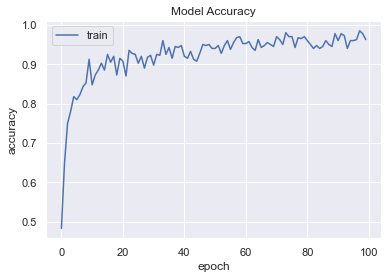

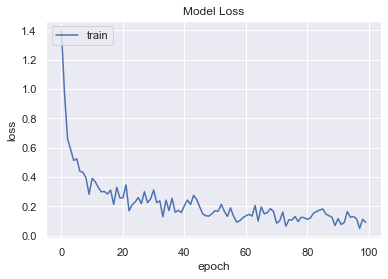

In [24]:
##########################
# # get model accuracy # #
##########################
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

######################
# # get model loss # #
######################
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [25]:
##########################
# # view model summary # #
##########################
model.model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 1, 128)            81920     
                                                                 
 dropout_33 (Dropout)        (None, 1, 128)            0         
                                                                 
 batch_normalization_33 (Bat  (None, 1, 128)           512       
 chNormalization)                                                
                                                                 
 lstm_34 (LSTM)              (None, 1, 128)            131584    
                                                                 
 dropout_34 (Dropout)        (None, 1, 128)            0         
                                                                 
 batch_normalization_34 (Bat  (None, 1, 128)           512       
 chNormalization)                                    

### MODEL TESTING
> * get model accuracy on the test dataset
> * generate confusion matrix
> * generate ROC curves
> * save the model if appropriate

In [26]:
y_pred = model.predict(X_test)
y_pred = to_categorical(y_pred)

# evaluate predictions
acc = accuracy_score(y_test, y_pred)
print("Testing accuracy: %.3f%%" % (acc*100))

Testing accuracy: 99.000%


##### Confusion Matrix

<AxesSubplot:>

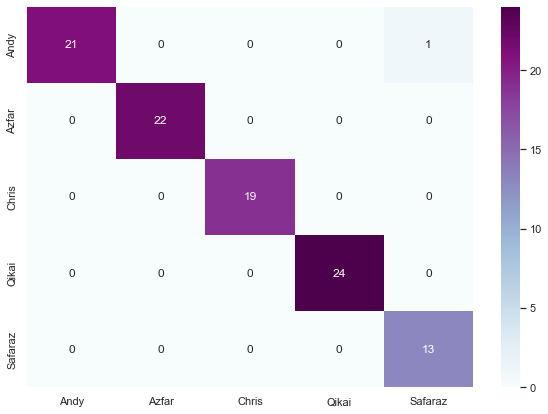

In [27]:
# confusion matrix
cm = confusion_matrix(encoder.inverse_transform(y_test), encoder.inverse_transform(y_pred))
df_cm = pd.DataFrame(cm, index = [i for i in np.unique(encoder.inverse_transform(y_test))], columns = [i for i in np.unique(encoder.inverse_transform(y_test))])

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap="BuPu")

##### ROC Curve (Individual)

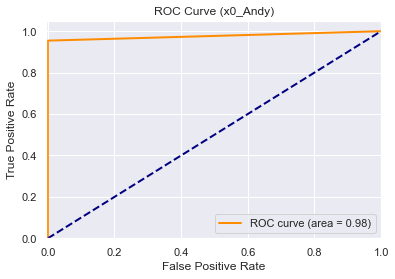

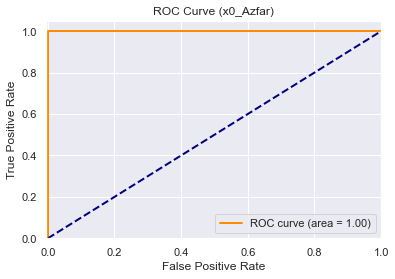

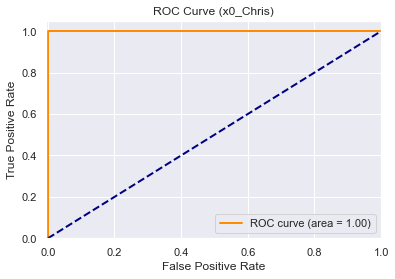

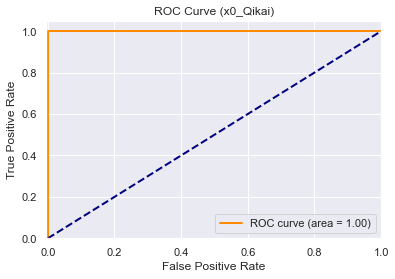

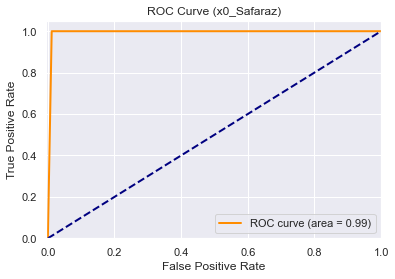

In [28]:
# compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.figure()
    lw = 2
    plt.plot(
        fpr[i],
        tpr[i],
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc[i],
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([-0.005, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (" + str(encoder.get_feature_names_out()[i]) + ")")
    plt.legend(loc="lower right")
    plt.show()

##### ROC Curve (Combined Plot)

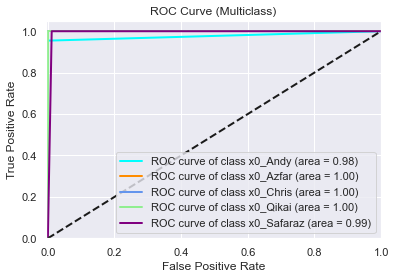

In [29]:
# compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], thresholds = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# first aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
# plt.figure()
# plt.plot(
#     fpr["micro"],
#     tpr["micro"],
#     label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
#     color="deeppink",
#     linestyle=":",
#     linewidth=4,
# )

# plt.plot(
#     fpr["macro"],
#     tpr["macro"],
#     label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
#     color="navy",
#     linestyle=":",
#     linewidth=4,
# )

colors = cycle(["aqua", "darkorange", "cornflowerblue", "lightgreen", "purple"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(encoder.get_feature_names_out()[i], roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([-0.005, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Multiclass)")
plt.legend(loc="lower right")
plt.show()

##### ROC Curve (Average out)

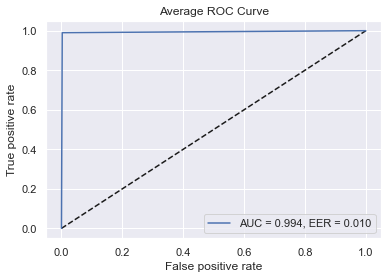

In [30]:
fpr, tpr, threshold = roc_curve(y_test.ravel(), y_pred.ravel())

# calculate equal-error-rate
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f}, EER = {:.3f}'.format(auc(fpr, tpr), eer))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Average ROC Curve')
plt.legend(loc='best')
plt.show()

### FIT AND SAVE MODEL
> * fitting of model
> * get accuracy and loss of model
> * saving model

In [50]:
##############################################
# # normalisation and reshaping of dataset # #
##############################################

# normalisation to 0 to 1
# scaler = MinMaxScaler(feature_range=(0, 1))
# X = scaler.fit_transform(X)

# reshaping the dataset to include LSTM Timesteps
X = np.asarray(X, dtype=np.float32)
X = np.reshape(X, (X.shape[0], TIMESTEPS, X.shape[1]))

#####################
# # fit the model # #
#####################

model = create_model()
es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                   verbose=0)
history = model.fit(X, Y, callbacks=es)

Epoch 1/100
50/50 [==============================] - 4s 4ms/step - loss: 1.2660 - accuracy: 0.5240
Epoch 2/100
50/50 [==============================] - 0s 4ms/step - loss: 0.7838 - accuracy: 0.6920
Epoch 3/100
50/50 [==============================] - 0s 4ms/step - loss: 0.6505 - accuracy: 0.7700
Epoch 4/100
50/50 [==============================] - 0s 4ms/step - loss: 0.5575 - accuracy: 0.8060
Epoch 5/100
50/50 [==============================] - 0s 4ms/step - loss: 0.4979 - accuracy: 0.8180
Epoch 6/100
50/50 [==============================] - 0s 4ms/step - loss: 0.4343 - accuracy: 0.8420
Epoch 7/100
50/50 [==============================] - 0s 4ms/step - loss: 0.3427 - accuracy: 0.8780
Epoch 8/100
50/50 [==============================] - 0s 4ms/step - loss: 0.3435 - accuracy: 0.8800
Epoch 9/100
50/50 [==============================] - 0s 4ms/step - loss: 0.3257 - accuracy: 0.8900
Epoch 10/100
50/50 [==============================] - 0s 4ms/step - loss: 0.2989 - accuracy: 0.8960
Epoch 11/

50/50 [==============================] - 0s 5ms/step - loss: 0.0876 - accuracy: 0.9660
Epoch 84/100
50/50 [==============================] - 0s 5ms/step - loss: 0.0903 - accuracy: 0.9700
Epoch 85/100
50/50 [==============================] - 0s 5ms/step - loss: 0.0913 - accuracy: 0.9780
Epoch 86/100
50/50 [==============================] - 0s 4ms/step - loss: 0.1407 - accuracy: 0.9500
Epoch 87/100
50/50 [==============================] - 0s 4ms/step - loss: 0.1105 - accuracy: 0.9580
Epoch 88/100
50/50 [==============================] - 0s 5ms/step - loss: 0.1445 - accuracy: 0.9480
Epoch 89/100
50/50 [==============================] - ETA: 0s - loss: 0.1163 - accuracy: 0.95 - 0s 5ms/step - loss: 0.1130 - accuracy: 0.9620
Epoch 90/100
50/50 [==============================] - 0s 4ms/step - loss: 0.1239 - accuracy: 0.9620
Epoch 91/100
50/50 [==============================] - 0s 4ms/step - loss: 0.1170 - accuracy: 0.9600
Epoch 92/100
50/50 [==============================] - 0s 4ms/step - los

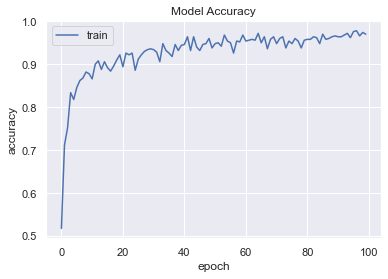

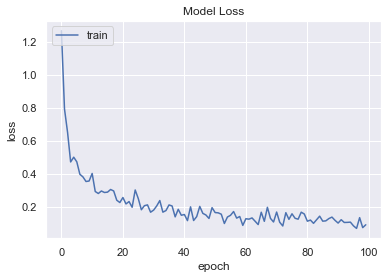

In [40]:
##########################
# # get model accuracy # #
##########################
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

######################
# # get model loss # #
######################
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

### SAVE MODEL

In [41]:
# ##################
# # # save model # #
# ##################

# model.model.save("model/key_classifier.h5")

# ###########################
# # # save model in colab # #
# ###########################

# # model.model.save(F"/content/gdrive/My Drive/Colab Notebooks/overall_key_classifier.h5")

### LOAD MODEL

In [42]:
# ##################
# # # load model # #
# ##################

# model = create_model()
# model.model = load_model("model/key_classifier.h5")

# ###########################
# # # load model in colab # #
# ###########################

# # model.model = load_model("/content/gdrive/My Drive/Colab Notebooks/overall_key_classifier.h5")

### LIVE TESTING
> * import any new data to perform testing and prediction

In [43]:
# import unseen data
pred_df = pd.read_csv(TEST_DATA_LINK)
pred_df.head()

,subject,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,...,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
0,Andy,1,1,0.174239,0.409866,0.235627,0.133840,0.171659,0.037820,0.156984,...,0.137544,0.091721,-0.045824,0.099726,0.099142,-0.000585,0.120912,0.135934,0.015022,0.163508
1,Andy,1,2,0.145289,0.154851,0.009562,0.131217,0.129134,-0.002083,0.130980,...,0.164865,0.111584,-0.053281,0.101935,0.023678,-0.078258,0.140863,0.192325,0.051462,0.156958
2,Andy,1,3,0.122266,0.136321,0.014055,0.114905,0.125308,0.010402,0.144332,...,0.145501,0.095982,-0.049520,0.121049,0.091486,-0.029563,0.111422,0.145751,0.034329,0.169304
3,Andy,1,4,0.121075,0.132562,0.011487,0.134813,0.132049,-0.002763,0.135681,...,0.135072,0.089715,-0.045356,0.117885,0.089209,-0.028676,0.098095,0.139069,0.040974,0.168298
4,Andy,1,5,0.141361,0.124721,-0.016640,0.098268,0.149003,0.050735,0.128713,...,0.121480,0.078897,-0.042583,0.108607,0.049435,-0.059172,0.131348,0.156398,0.025050,0.170112


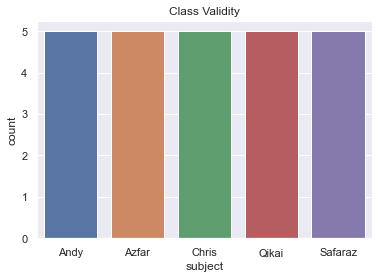

In [36]:
################################
# # check for class validity # #
################################
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="subject", data=pred_df).set_title("Class Validity")

# remove missing values if available
pred_df = pred_df.dropna()

In [51]:
pred_dataset = pred_df.values

# divide data into features X
# X_new = new_dataset[:,3:].astype(float)

#################################
# # predict more than one row # #
#################################

pred_row=pred_df.iloc[:,3:]

############################
# # predict a single row # #
############################

# pred_row=pred_df.iloc[0:2,3:]

################################
# # normalise and shape data # #
################################
pred_row = pred_row.values.tolist()
# pred_row = scaler.transform(pred_row)
pred_arr = np.asarray(pred_row, dtype=np.float32)
pred_arr = np.reshape(pred_arr, (pred_arr.shape[0], TIMESTEPS, pred_arr.shape[1]))

In [52]:
####################################
# # get prediction and its label # #
####################################

pred = model.predict(pred_arr)
pred = to_categorical(pred)
pred = encoder.inverse_transform(pred)
pred = np.ravel(pred)

pred_proba = model.predict_proba(pred_arr)
acc = np.max(pred_proba, axis=1)

pred_results = np.column_stack((pred, acc))

df = pd.DataFrame(data=pred_results, index=None, columns=['Prediction', 'Accuracy'])
print(df)

   Prediction  Accuracy
0        Andy   0.99851
1        Andy   0.99995
2        Andy  0.999869
3        Andy  0.999918
4        Andy  0.996753
5       Azfar  0.999834
6       Azfar  0.999939
7       Azfar  0.999923
8       Azfar  0.999915
9       Azfar  0.999865
10      Chris  0.998979
11      Chris  0.981776
12      Chris  0.999934
13      Chris  0.999614
14      Chris  0.998476
15      Qikai  0.997311
16      Qikai  0.996062
17      Qikai    0.9956
18      Qikai  0.994196
19      Qikai  0.999083
20    Safaraz  0.972109
21    Safaraz  0.942647
22    Safaraz  0.985633
23    Safaraz  0.960853
24    Safaraz  0.938634
